In [1]:
import numpy as np
import sys
import mne
sys.path.insert(1, '../../MEG/Code')
mne.utils.set_config("SUBJECTS_DIR", '~/MEG/Data/MRIs', set_env=True)
from visualisations_brain import *
import importlib
import kuramoto
from kuramoto import KuramotoNetwork

In [2]:
importlib.reload(kuramoto)
from kuramoto import KuramotoNetwork

## 1. Kuramoto model 

The oscillatory mechanism (which does not depend on the spike rate) can be run first. This is done using the KuramotoNetwork class.

In [3]:
from sklearn.preprocessing import normalize
import kuramoto
from kuramoto import KuramotoNetwork

In [4]:
def update_sc(sc, state, collapse_subcort=True):
    """
    Updates the structual connectivity matrix such that a certain cortical network is synchronized
    """
    sc = normalize(sc, norm='l1')
    if state == 'maintenance':
        idx = np.array([14,  15,  21,  22,  23,  24,  26,  29,  43,  44,  52,  53,  54, 55,  57,  59,  60,  61,  62,  63,  64,  65,  66,  
                        77,  78, 79, 81,  82,  83,  85,  86,  87,  88,  89,  90,  91,  93,  95,  96, 97,  98,  99, 114, 115, 122, 126, 127, 
                        137, 141, 149, 150, 151, 153, 155, 156, 157, 158, 159, 160, 161, 173, 174, 175, 176, 179, 181, 182, 183, 184, 185, 
                        186, 187, 188, 189, 190, 192, 196, 197, 198])
    elif state == 'encoding':
        idx = np.array([14,  23,  26,  40,  41,  42,  44,  50,  51,  53,  56,  58,  59, 63,  64,  65,  78, 100, 101, 102, 103, 104, 
                              105, 106, 107, 108, 109, 110, 111, 112, 113, 127, 128, 129, 130, 139, 140, 141, 147, 148, 149, 152, 153, 154, 
                              157, 158, 159, 160, 161, 174, 177, 184, 188, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 
                              212, 213])

    if collapse_subcort == True:
        idx = idx - 12

    if collapse_subcort == False:
        sc[idx, 2] = sc[idx, 2]*50
        sc[idx, 3] = sc[idx, 3]*50
        sc[idx, 4] = sc[idx, 4]*50
        sc[idx, 5] = sc[idx, 5]*50
    
        sc[idx, 9] = sc[idx, 9]*50
        sc[idx, 10] = sc[idx, 10]*50
        sc[idx, 11] = sc[idx, 11]*50
        sc[idx, 12] = sc[idx, 12]*50

    if collapse_subcort == True: 
        sc[idx, 0] = sc[idx, 0]*50
        sc[idx, 1] = sc[idx, 1]*50    

    return sc

In [5]:
def collapse_subcort(sc, dist):
    """
    If the basal-ganglia and thalamus nodes should be collapsed into one, and the other subcortical nodes removed, run this function.
    """
    sc = normalize(sc, norm='l1')

    sc_mean1_lh = np.sum(sc[2:6],axis=0)
    sc_mean2_lh = np.sum(sc[:,2:6],axis=1)
    sc_mean1_rh = np.sum(sc[9:13],axis=0)
    sc_mean2_rh = np.sum(sc[:,9:13],axis=1)
    
    dist_mean1_lh = np.mean(dist[2:6],axis=0)
    dist_mean2_lh = np.mean(dist[:,2:6],axis=1)
    dist_mean1_rh = np.mean(dist[9:13],axis=0)
    dist_mean2_rh = np.mean(dist[:,9:13],axis=1)
    
    sc = sc[12:,12:]
    dist = dist[12:,12:]
    
    sc[0] = sc_mean1_lh[12:]
    sc[:,0] = sc_mean2_lh[12:]

    sc[1] = sc_mean1_rh[12:]
    sc[:,1] = sc_mean2_rh[12:]
    
    sc[0,0] = 0
    sc[1,1] = 0
    
    dist[0] = dist_mean1_lh[12:]
    dist[:,0] = dist_mean2_lh[12:]
    
    dist[1] = dist_mean1_rh[12:]
    dist[:,1] = dist_mean2_rh[12:]
    
    dist[0,0] = 0
    dist[1,1] = 0

    return sc, dist 

In [6]:
on = KuramotoNetwork(itt=100000, network = np.load('/Users/julia.ericson/States/Data/ConnectivityMatrices/sc_matrix{}.npy'.format(10)), 
                     distances=np.load('/Users/julia.ericson/States/Data/DistanceMatrices/distance_matrix{}.npy'.format(10)), omega=0.04*np.ones(214))

### 1.1 Run the Kuramoto model

The simulation runs 100000 itterations for 10 subjects that each have their own structual network. It runs both 'encoding' and 'maintenance' states. 

The structual network can either be run with 7 subcortical nodes in each hemisphere (set collapse = False), or 1 subcortical node (set collapse = True). The results should be fairly similar, but I have perferred to run with only 1 subcortical node as I believe that the model simulates a cortical phenomenon which does not capture the interaction between subcortical nodes.

In [7]:
collapse = True

In [17]:
states = ['maintenance', 'encoding']
subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

itt = 100000
if collapse == False:
    omega=0.04*np.ones(214)
else:
    omega=0.04*np.ones(202) 

for s in subjects:
    print('subject:', s)
    for state in states:
        if state == 'maintenance':
            if collapse == True:
                omega[[0,1]] = 0.01  # for maintenance, set the thalamic oscillations to 10 Hz 
            if collapse == False:
                omega[[2,9,3,10,4,11,5,12]] = 0.01
        if state == 'encoding':
            if collapse == True:
                omega[[0,1]] = 0.005  # for encoding, set the thalamic oscillations to 5 Hz 
            if collapse == False:
                omega[[2,9,3,10,4,11,5,12]] = 0.005    
        dist = np.load('DataSimulation/DistanceMatrices/distance_matrix{}.npy'.format(s)).astype(int)
        sc = np.load('DataSimulation/ConnectivityMatrices/sc_matrix{}.npy'.format(s))
        sc, dist = collapse_subcort(sc, dist)
        sc = update_sc(sc, state, collapse_subcort=collapse)

        on = KuramotoNetwork(itt, sc, dist, sigma=0.05, omega=omega)
        on.run_simulation()

        np.save('DataSimulation/OscillationTimeSeries/{}_network_striatum{}.npy'.format(state, s), on.theta)

subject: 1
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
subject: 2
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
subject: 3
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
subject: 4
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
subject: 5
0
5000
10000
15000
20000


### 1.2 Visualize

Visualize the synchronization in the simulated time series. The visualization package needs input from MR data, and can therefore not be run here. (Come up with a better solution if time)

1
2
3
4
5
6
7
8
9
10
Reading forward solution from /Users/julia.ericson/States/Code/../../MEG/Data/0901/220207/M10901_fwd_fixed.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (13539 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Reading labels from parcellation...
   read 101 labels from /Users/julia.ericson/MEG/Data/MRIs/0901MRI/label/lh.parc2018yeo7_200.annot
Reading labels from parcellation...
   read 101 labels from /Users/julia.ericson/MEG/Data/MRIs/0901MRI/label/rh.parc2018yeo7_200.annot


/Users/julia.ericson/States/Code/../../MEG/Code/visualisations_brain.py:34: RuntimeWarning: This filename (../../MEG/Data/0901/220207/M10901_fwd_fixed.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif, _fwd.fif.gz, -fwd.h5 or _fwd.h5
  fwd_fixed = mne.read_forward_solution(fwd_fixed_path)
/Users/julia.ericson/States/Code/../../MEG/Code/visualisations_brain.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar_ticklabels, va='center')


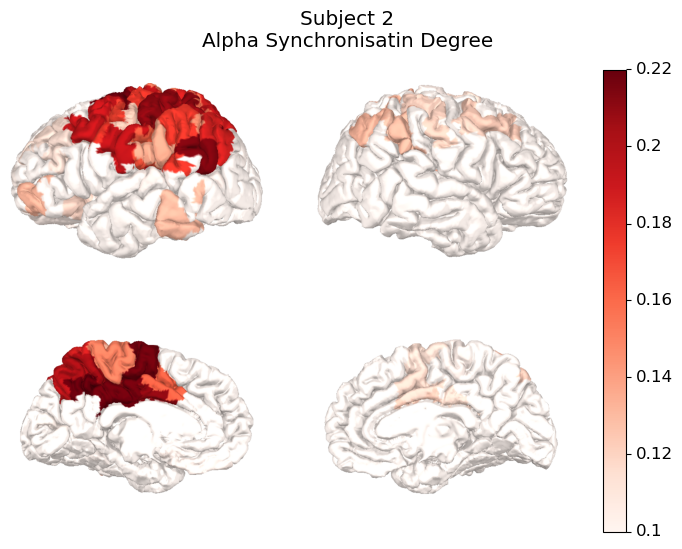

In [11]:
state = 'maintenance'
synch_all = np.zeros((202,202))
for i in range(1,11):
    print(i)
    phase = np.load('DataSimulation/OscillationTimeSeries/{}_network_striatum{}.npy'.format(state, i))
    synch = on.calculate_synchrony(phase, imag=False)
    synch_all += synch

synch_all = synch_all/10
data = np.mean(synch_all[2:,2:],axis=1) 
max_val = np.max(data)
vis_data_on_brain(s='0901', data=data, title='Alpha Synchronisatin Degree', cmin=0.1, cmax=0.22,
                  fwd_fixed_path='../../MEG/Data/{}/{}/M{}{}_fwd_fixed.fif'.format('0901', '220207', '1', '0901'), 
                  mri_dir='~/MEG/Data/MRIs', cmap='Reds')

## 2. Spiking Model

Runs the spike rate simulation using data from the Kuramoto model simulation.

In [20]:
n_sources = 214  # number of network nodes before collapsing
start = 2000  # starting time point for the spike rate simulation (with respect to the silmulated time series from the Kuramoto model)
time_points = 100000 - 2000  # number of illerations
k = 0.8 
decay = 0.25
w_dists = 2
dt = 0.1
collapse = True

In [21]:
states = ['maintenance', 'encoding']
subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
areas = [111, 60]
if collapse == True:
    areas = [111 - 12, 60 - 12] 
    n_sources = 202

for s in subjects:
    print('subject:', s)
    dist = np.load('DataSimulation/DistanceMatrices/distance_matrix{}.npy'.format(s)).astype(int)
    sc = np.load('DataSimulation/ConnectivityMatrices/sc_matrix{}.npy'.format(s))
    sc, dist = collapse_subcort(sc, dist)
    
    for state in states:
        for n in areas:
            I_external = np.zeros((start+time_points, n_sources))
            u = np.zeros((start+time_points, n_sources))
            I_external[:,n] = 1
            oscillations = np.load('DataSimulation/OscillationTimeSeries/{}_network_striatum{}.npy'.format(state, s))
            oscillations = np.sin(oscillations)*(-0.5) + 0.5
                
            for t in range(start,start+time_points):
                for i in range(n_sources):
                    delays = u[t - w_dist*dist[i], np.arange(n_sources)]
                    u[t,i] = (u[t-1,i] + dt*(I_external[t,i] + k*np.dot(sc[i], delays) - decay*u[t-1,i]))*oscillations[t,i]
        
            np.save('DataSimulation/SpikeRateTimeSeries/{}_network_{}_striatum{}.npy'.format(state, n, s),u)

subject: 1
subject: 2
subject: 3
subject: 4
subject: 5
subject: 6
subject: 7
subject: 8
subject: 9
subject: 10


## 3. Entropy calculations

Calculate the entropy transfer from one node to the rest of the brain using the spike rate simulated data. 

In [8]:
import pandas as pd
import seaborn as sns

In [22]:
def dTE_calc(probs):
    """
    Calculates transfer entropy.
    """
    size = probs.shape[0]
    dTE = 0
    pj = np.sum(np.sum(probs, axis=2), axis=0)
    pj_jd = np.sum(probs, axis=0)
    pi_j = np.sum(probs, axis=2)
    for i in range(size):
        for j in range(size):
            for k in range(size):
                nom = probs[i, j, k] * pj[j]
                denom = pj_jd[j, k] * pi_j[i, j]
                if (nom != 0) & (denom != 0):
                    dTE += probs[i, j, k] * np.log(nom/denom)
    return dTE

def calculate_information_transfer(xi, x_dat, d_dat):
    """
    1) Makes the propability distribution plots
    2) Calls on dTE_calc to get the transfer entropy for the current probablity distributions. 
    """
    dTE = []
    for xj in range(x_dat.shape[1]):
        if xi != xj:
            hist_probs = np.concatenate((x_dat[:,[xi, xj]], np.expand_dims(d_dat[:,xj], axis=1)),axis=1)
            hist_random, edges = np.histogramdd(hist_probs, bins=20, density=True, range=[(0,20), (0,20), (0,20)])
            dTE.append(dTE_calc(hist_random))
        else:
            dTE.append(0)
    return dTE

### 3.1 Run simulation

In [25]:
states = ['maintenance', 'encoding']
subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
areas = [111, 60]
if collapse == True:
    areas = [111 - 12, 60 - 12] 
dN = 400  # The max delta T. This means that transfer entropy is calculated for delta T = 1 to delta T = 400. 

for s in subjects:
    print('subject:', s)
    for state in states:
        for n in areas:
            u = np.load('DataSimulation/SpikeRateTimeSeries/{}_network_{}_striatum{}.npy'.format(state, n, s))
            u = np.divide(u, np.std(u,axis=0), out=np.zeros_like(u), where=np.std(u,axis=0)!=0)
                
            dTE_int = np.zeros(u.shape[1])
            T = u.shape[0]
                
            for d in range(1,dN+1):
                x_dat = u[:T - dN]
                d_dat = u[d:T - dN + d]
                dTE = calculate_information_transfer(n, x_dat, d_dat)
                dTE_int += dTE
            dTE_int /= dN
            np.save('DataSimulation/EntropyTransfer/{}/{}_{}.npy'.format(state, n, s),dTE_int)

subject: 1
subject: 2
subject: 3
subject: 4
subject: 5
subject: 6
subject: 7
subject: 8
subject: 9
subject: 10


### 3.2 Visualize the results. 

As for the synchronization visualization, the vis_data_on_brain function won't work at the moment. 

Reading forward solution from /Users/julia.ericson/States/Code/../../MEG/Data/0901/220207/M10901_fwd_fixed.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (13539 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Reading labels from parcellation...
   read 101 labels from /Users/julia.ericson/MEG/Data/MRIs/0901MRI/label/lh.parc2018yeo7_200.annot
Reading labels from parcellation...
   read 101 labels from /Users/julia.ericson/MEG/Data/MRIs/0901MRI/label/rh.parc2018yeo7_200.annot


/Users/julia.ericson/States/Code/../../MEG/Code/visualisations_brain.py:34: RuntimeWarning: This filename (../../MEG/Data/0901/220207/M10901_fwd_fixed.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif, _fwd.fif.gz, -fwd.h5 or _fwd.h5
  fwd_fixed = mne.read_forward_solution(fwd_fixed_path)
/Users/julia.ericson/States/Code/../../MEG/Code/visualisations_brain.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar_ticklabels, va='center')


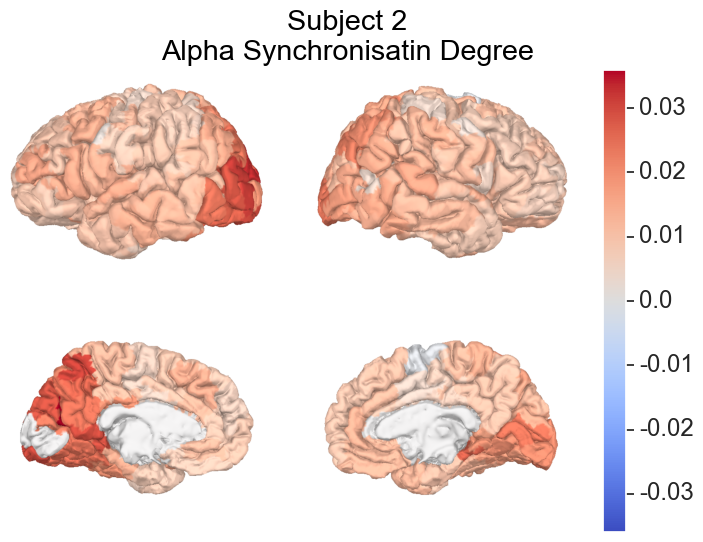

In [59]:
state1 = 'maintenance'
state2 = 'encoding'
n = 111 - 12
w_dist = 2

dTE_int_all = np.zeros(202)
for s in range(1,11):
    dTE_int = np.load('DataSimulation/EntropyTransfer/{}/{}_{}.npy'.format(state2, n, s))
    dTE_int -= np.load('DataSimulation/EntropyTransfer/{}/{}_{}.npy'.format(state1, n, s))
    dTE_int_all += dTE_int

dTE_int_all = dTE_int_all/10
data = dTE_int_all[2:]
max_val = np.max(data)
vis_data_on_brain(s='0901', data=data, title='Alpha Synchronisatin Degree', cmin=-1*max_val, cmax=max_val,
                  fwd_fixed_path='../../MEG/Data/{}/{}/M{}{}_fwd_fixed.fif'.format('0901', '220207', '1', '0901'), 
                  mri_dir='~/MEG/Data/MRIs', cmap='coolwarm')

Note: for the following, EntropyTransfer is without thalamic drive and tau = 1, EntropyTransfer2 is with thalamic drive and tau = 1, EntropyTransfer3 is with thalamic drive and tau = 2

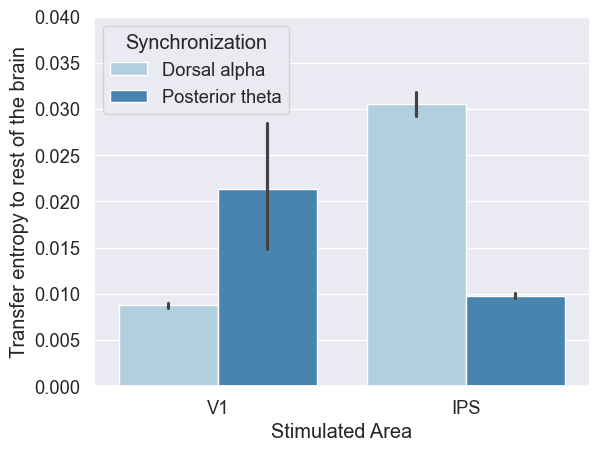

In [49]:
for s in range(1,11):
    
    dTE_int1 = np.load('DataSimulation/EntropyTransfer/{}/{}_{}.npy'.format('maintenance', 111-12, s))
    dTE_int2 = np.load('DataSimulation/EntropyTransfer/{}/{}_{}.npy'.format('encoding', 111-12, s))
    
    dTE_int3 = np.load('DataSimulation/EntropyTransfer/{}/{}_{}.npy'.format('maintenance', 60-12, s))
    dTE_int4 = np.load('DataSimulation/EntropyTransfer/{}/{}_{}.npy'.format('encoding', 60-12, s))

    df1 = pd.DataFrame({'Transfer entropy to rest of the brain': np.mean(dTE_int1), 'Synchronization': ['Dorsal alpha'], 'Stimulated Area': ['V1']})
    df2 = pd.DataFrame({'Transfer entropy to rest of the brain': np.mean(dTE_int2), 'Synchronization': ['Posterior theta'], 'Stimulated Area': ['V1']})
    df3 = pd.DataFrame({'Transfer entropy to rest of the brain': np.mean(dTE_int3), 'Synchronization': ['Dorsal alpha'], 'Stimulated Area': ['IPS']})
    df4 = pd.DataFrame({'Transfer entropy to rest of the brain': np.mean(dTE_int4), 'Synchronization': ['Posterior theta'], 'Stimulated Area': ['IPS']})

    if s == 1:
        df = pd.concat([df1, df2, df3, df4])
    else:
        df = pd.concat([df, df1, df2, df3, df4])

sns.set(font_scale=1.2)
sns.barplot(x = 'Stimulated Area',
            y = 'Transfer entropy to rest of the brain',
            hue = 'Synchronization',
            data = df,
            palette = "Blues")

plt.ylim(0,0.04)
plt.show()

## 4. Entropy from other areas

As a final investigation, we look at information flowing into the network instead of the other way around. We have no clear hypothesis of which node to stimulate here so we stimulate all the nodes which are not in one of the networks.

Note that the spiking time series for these simulations are not stored in the Data folder due to limited storage. 

In [10]:
collapse = True

In [11]:
n_sources = 214
start = 2000
time_points = 100000 - 2000 
k=0.8 
decay = 0.25
dt = 0.1

In [19]:
idx = np.array([14,  15,  21,  22,  23,  24,  26,  29,  43,  44,  52,  53,  54, 55,  57,  59,  60,  61,  62,  63,  64,  65,  66,  77,  78, 
                79, 81, 82,  83,  85,  86,  87,  88,  89,  90,  91,  93,  95,  96, 97,  98,  99, 40,  41,  42, 50,  51, 56,  58, 100, 101, 
                102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113])
areas = np.arange(14,114) 
areas = areas[~np.isin(areas,idx)]  # areas = areas not in one of the two networks
areas

array([16, 17, 18, 19, 20, 25, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 45, 46, 47, 48, 49, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 80,
       84, 92, 94])

### 4.1 Spiking model

In [20]:
states = ['maintenance', 'encoding']
subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
if collapse == True:
    areas = areas - 12 
    n_sources = 202
w_dists = [2]

for s in subjects:
    print('subject:', s)
    dist = np.load('DataSimulation/DistanceMatrices/distance_matrix{}.npy'.format(s)).astype(int)
    sc = np.load('DataSimulation/ConnectivityMatrices/sc_matrix{}.npy'.format(s))
    # sc = normalize(sc, norm='l1')
    sc, dist = collapse_subcort(sc, dist)
    
    for state in states:
        for n in areas:
            for w_dist in w_dists:
                I_external = np.zeros((start+time_points, n_sources))
                u = np.zeros((start+time_points, n_sources))
                I_external[:,n] = 1
                oscillations = np.load('DataSimulation/OscillationTimeSeries/{}_network_striatum{}.npy'.format(state, s))
                oscillations = np.sin(oscillations)*(-0.5) + 0.5
                
                for t in range(start,start+time_points):
                    for i in range(n_sources):
                        delays = u[t - w_dist*dist[i], np.arange(n_sources)]
                        u[t,i] = (u[t-1,i] + dt*(I_external[t,i] + k*np.dot(sc[i], delays) - decay*u[t-1,i]))*oscillations[t,i]
        
                np.save('DataSimulation/SpikeRateTimeSeries/{}_network_{}_striatum{}.npy'.format(state, n, s),u)

subject: 3
subject: 4
subject: 5
subject: 6
subject: 7
subject: 8
subject: 9
subject: 10


### 4.2 Entropy calculations

In [23]:
dN = 200

for s in subjects:
    print('subject:', s)
    for state in states:
        for n in areas:
            for w_dist in w_dists:
                u = np.load('DataSimulation/SpikeRateTimeSeries/{}_network_{}_striatum{}.npy'.format(state, n, s))
                u = np.divide(u, np.std(u,axis=0), out=np.zeros_like(u), where=np.std(u,axis=0)!=0)
                
                dTE_int = np.zeros(u.shape[1])
                T = u.shape[0]
                
                for d in range(1,dN+1):
                    # print(d)
                    x_dat = u[:T - dN]
                    d_dat = u[d:T - dN + d]
                    dTE = calculate_information_transfer(n, x_dat, d_dat)
                    dTE_int += dTE
                dTE_int /= dN
                np.save('DataSimulation/EntropyTransfer/{}/{}_{}.npy'.format(state, n, s),dTE_int)

subject: 1
subject: 2
subject: 3
subject: 4
subject: 5
subject: 6
subject: 7
subject: 8
subject: 9
subject: 10


### 4.3 Visualize entropy from other areas

Reading forward solution from /Users/julia.ericson/States/Code/../../MEG/Data/0901/220207/M10901_fwd_fixed.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (13539 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Reading labels from parcellation...
   read 101 labels from /Users/julia.ericson/MEG/Data/MRIs/0901MRI/label/lh.parc2018yeo7_200.annot
Reading labels from parcellation...
   read 101 labels from /Users/julia.ericson/MEG/Data/MRIs/0901MRI/label/rh.parc2018yeo7_200.annot


/Users/julia.ericson/States/Code/../../MEG/Code/visualisations_brain.py:34: RuntimeWarning: This filename (../../MEG/Data/0901/220207/M10901_fwd_fixed.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif, _fwd.fif.gz, -fwd.h5 or _fwd.h5
  fwd_fixed = mne.read_forward_solution(fwd_fixed_path)
/Users/julia.ericson/States/Code/../../MEG/Code/visualisations_brain.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar_ticklabels, va='center')


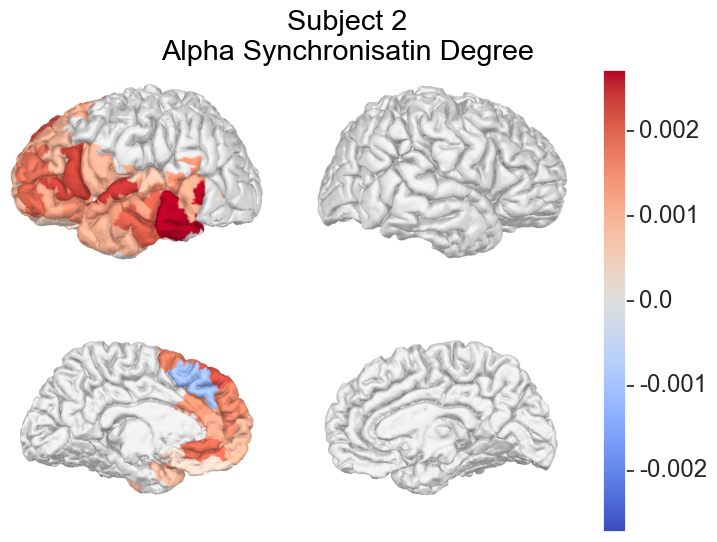

In [54]:
network = 'maintenance'

subjects = [1,2,3,4,5,6,7,8,9,10]
outside = np.array([16, 17, 18, 19, 20, 25, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 45, 46, 47, 48, 49, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 80,
       84, 92, 94]) - 12 

if network == 'maintenance':
    idx_network = np.array([ 14,  15,  21,  22,  23,  24,  26,  29,  43,  44,  52,  53,  54, 55,  57,  59,  60,  61,  62,  63,  64,  65,  66,  
                             77,  78, 79, 81,  82,  83,  85,  86,  87,  88,  89,  90,  91,  93,  95,  96, 97,  98,  99, 114, 115, 122, 126, 127, 
                             137, 141, 149, 150, 151, 153, 155, 156, 157, 158, 159, 160, 161, 173, 174, 175, 176, 179, 181, 182, 183, 184, 185, 
                             186, 187, 188, 189, 190, 192, 196, 197, 198])

else:
    idx_network = np.array([14,  23,  26,  40,  41,  42,  44,  50,  51,  53,  56,  58,  59, 63,  64,  65,  78, 100, 101, 102, 103, 104, 105, 106,
                           107, 108, 109, 110, 111, 112, 113, 127, 128, 129, 130, 139, 140, 141, 147, 148, 149, 152, 153, 154, 157, 158, 159, 
                           160, 161, 174, 177, 184, 188, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213])
idx_all = np.arange(14,214)

dTE_int = np.zeros(200)
for s in subjects: 
    for n in outside:
        dTE_int[n-2] += np.mean(np.load('DataSimulation/EntropyTransfer/maintenance/{}_{}.npy'.format(n, s))[idx_network-14])
        dTE_int[n-2] -= np.mean(np.load('DataSimulation/EntropyTransfer/encoding/{}_{}.npy'.format(n, s))[idx_network-14])

dTE_int = dTE_int/len(subjects)
max_val = np.max(dTE_int)  # 0.003 
vis_data_on_brain(s='0901', data=dTE_int, title='Alpha Synchronisatin Degree', cmin=-max_val, cmax=max_val,
                  fwd_fixed_path='../../MEG/Data/{}/{}/M{}{}_fwd_fixed.fif'.format('0901', '220207', '1', '0901'), 
                  mri_dir='~/MEG/Data/MRIs', cmap='coolwarm')  # np.max(plot_mat)

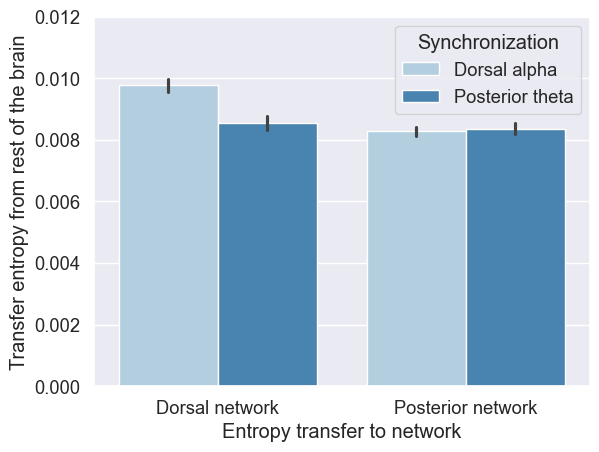

In [50]:
outside = np.array([16, 17, 18, 19, 20, 25, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 45, 46, 47, 48, 49, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 80,
       84, 92, 94]) - 12 

idx_maintenance = np.array([ 14,  15,  21,  22,  23,  24,  26,  29,  43,  44,  52,  53,  54, 55,  57,  59,  60,  61,  62,  63,  64,  65,  66,  
                             77,  78, 79, 81,  82,  83,  85,  86,  87,  88,  89,  90,  91,  93,  95,  96, 97,  98,  99, 114, 115, 122, 126, 127, 
                             137, 141, 149, 150, 151, 153, 155, 156, 157, 158, 159, 160, 161, 173, 174, 175, 176, 179, 181, 182, 183, 184, 185, 
                             186, 187, 188, 189, 190, 192, 196, 197, 198])

idx_encoding = np.array([14,  23,  26,  40,  41,  42,  44,  50,  51,  53,  56,  58,  59, 63,  64,  65,  78, 100, 101, 102, 103, 104, 105, 106,
                           107, 108, 109, 110, 111, 112, 113, 127, 128, 129, 130, 139, 140, 141, 147, 148, 149, 152, 153, 154, 157, 158, 159, 
                           160, 161, 174, 177, 184, 188, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213])

for s in range(1,11):

    dTE_int1 = 0
    dTE_int2 = 0
    dTE_int3 = 0
    dTE_int4 = 0
    
    for n in outside:
        dTE_int1 += np.mean(np.load('DataSimulation/EntropyTransfer/maintenance/{}_{}.npy'.format(n, s))[idx_maintenance-14])
        dTE_int2 += np.mean(np.load('DataSimulation/EntropyTransfer/encoding/{}_{}.npy'.format(n, s))[idx_maintenance-14])

    for n in outside:
        dTE_int3 += np.mean(np.load('DataSimulation/EntropyTransfer/maintenance/{}_{}.npy'.format(n, s))[idx_encoding-14])
        dTE_int4 += np.mean(np.load('DataSimulation/EntropyTransfer/encoding/{}_{}.npy'.format(n, s))[idx_encoding-14])
    

    df1 = pd.DataFrame({'Transfer entropy from rest of the brain': dTE_int1/outside.shape[0], 'Synchronization': ['Dorsal alpha'], 'Entropy transfer to network': ['Dorsal network']})
    df2 = pd.DataFrame({'Transfer entropy from rest of the brain': dTE_int2/outside.shape[0], 'Synchronization': ['Posterior theta'], 'Entropy transfer to network': ['Dorsal network']})
    df3 = pd.DataFrame({'Transfer entropy from rest of the brain': dTE_int3/outside.shape[0], 'Synchronization': ['Dorsal alpha'], 'Entropy transfer to network': ['Posterior network']})
    df4 = pd.DataFrame({'Transfer entropy from rest of the brain': dTE_int4/outside.shape[0], 'Synchronization': ['Posterior theta'], 'Entropy transfer to network': ['Posterior network']})

    if s == 1:
        df = pd.concat([df1, df2, df3, df4])
    else:
        df = pd.concat([df, df1, df2, df3, df4])

sns.set(font_scale=1.2)
sns.barplot(x = 'Entropy transfer to network',
            y = 'Transfer entropy from rest of the brain',
            hue = 'Synchronization',
            data = df,
            palette = "Blues")

plt.ylim(0,0.012)
plt.show()


### 4.4 Significance test of transfer entropy difference

In [25]:
from scipy import stats

In [27]:
df_maintain = df[df.State == 'Maintain']
df_encode = df[df.State == 'Encode']
t1 = df_maintain[df_maintain['Entropy transfer to network'] == 'Maintenance network']['Transfer entropy from rest of the brain'].values
t2 = df_maintain[df_maintain['Entropy transfer to network'] == 'Encoding network']['Transfer entropy from rest of the brain'].values

t3 = df_encode[df_encode['Entropy transfer to network'] == 'Maintenance network']['Transfer entropy from rest of the brain'].values
t4 = df_encode[df_encode['Entropy transfer to network'] == 'Encoding network']['Transfer entropy from rest of the brain'].values

stats.ttest_ind(t1, t2), stats.ttest_ind(t3, t4)

(TtestResult(statistic=10.811470212058316, pvalue=2.653288106444717e-09, df=18.0),
 TtestResult(statistic=1.263746302415361, pvalue=0.2224433760484038, df=18.0))